# 05_non-blocking / callback

In [1]:
import wave
import pyaudio

buffer_size = 1024
pa = pyaudio.PyAudio()
wf = wave.open(r'jazz.wav')

# open wav file in callback mode
def call_out(in_data, frame_count, time_info, status_flags):
    out_data = wf.readframes(buffer_size)
    
    return out_data, pyaudio.paContinue

In [2]:
pa = pyaudio.PyAudio()
stream_out = pa.open(rate=48000, channels=2, format=pyaudio.paInt16,
                     frames_per_buffer=buffer_size, output=True,
                     stream_callback=call_out, start=False)

In [3]:
stream_out.start_stream() # open file without blocking access

In [4]:
stream_out.stop_stream() # stop

In [5]:
import numpy as np
input_array = np.zeros(96000*10, dtype=np.int16)
counter = 0

# save input stream to array, callback
def call_in(in_data, frame_count, time_info, status_flags):
    global counter
    input_array[counter*buffer_size*2:(counter+1)*buffer_size*2] = np.frombuffer(in_data, dtype=np.int16)
    counter += 1
    
    out_data = None
    return out_data, pyaudio.paContinue

In [6]:
stream_in = pa.open(rate=48000, channels=2, format=pyaudio.paInt16,
                    frames_per_buffer=buffer_size, input=True,
                    stream_callback=call_in, start=False)

In [7]:
stream_in.start_stream()

In [8]:
stream_in.stop_stream()

In [9]:
import time
import matplotlib
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


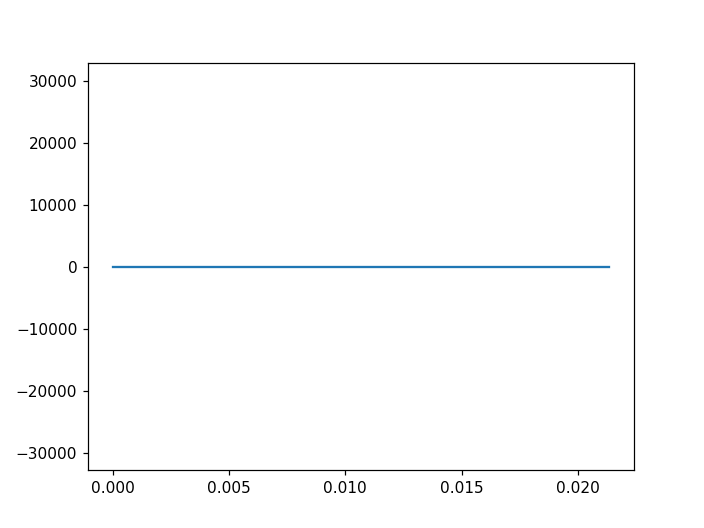

In [10]:
# funkcja draw do rysowania przebiegu sygnału w czasie rzeczywistym
# należy przekazać ją jako argument stream_callback podczas tworzenia strumienia wejściowego
%matplotlib notebook

RATE = 48000
BUFFER = 1024
matplotlib.interactive(True)
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, BUFFER/RATE, num=BUFFER)
y = np.zeros(BUFFER)

ax.set_ylim(-2**15, 2**15-1)
ch_plot, = ax.plot(x, y)
fig.show()

def draw(in_data, frame_count, time_info, status):
    audio_in = np.frombuffer(in_data, dtype=np.int16)
    
    ch_plot.set_ydata(audio_in[:BUFFER])
    plt.draw()
    time.sleep(0.00001)
    out_data = None
    
    return out_data, pyaudio.paContinue

In [11]:
# zadanie: prosty efekt z wykorzystaniem funkcji callback
delay_line = np.zeros(buffer_size*100, dtype=np.int16)

def delay(in_data, frame_number, time):
    global delay_line
    delay_s = buffer_size*10
    
    delay_line = np.roll(delay_line, buffer_size*2)
    
    # dalsza implementacja:
    # po każdym obrocie delay_line dane z bufora (in_data o rozmiarze buffer_size) należy zapisać na początkowych indeksach tablicy
    # następnie out_data = in_data + fragment lini opóźniającej, przesunięty o wartość delay_s
    # efekt można dostroić dodając kolejne składowe o różnych opóźnieniach; jeśli dodatkowo zostaną przefiltrowane otrzymamy prosty pogłos